In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.cpu, "/O2 /fp:fast /openmp")

S = 512

def matmul():
    A = tf.input([-1, -1], tf.float32)
    B = tf.input([-1, -1], tf.float32)

    N, M = A.shape
    K = B.shape[1]
    
    C = tf.zeros([N, K])

    i, j, k = tf.indices([N, K, M])

    tf.scatterAdd(C[i, j], A[i, k] * B[k, j])

    return [C]

mmul = tf.program(matmul)

TensorFrost module loaded!
TensorProgram:
  Kernel count: 2
  Intermediate buffers: 5
  Lines of generated code: 124
  IR size: 58



In [2]:
Anp = np.random.rand(S, S).astype(np.float32)
Bnp = np.random.rand(S, S).astype(np.float32)

A = tf.memory(Anp)
B = tf.memory(Bnp)
C, = mmul(A, B)

Cnp = C.numpy

#compare to numpy
Cnp2 = Anp @ Bnp

print(Cnp)
print(Cnp2)
print(Cnp - Cnp2)


[[127.6846   129.34894  127.655365 ... 127.56562  133.92336  120.45647 ]
 [131.5124   135.07002  128.37993  ... 133.85518  134.0026   129.8372  ]
 [127.3806   130.60928  127.20872  ... 131.428    136.22443  121.18091 ]
 ...
 [130.76495  131.09497  126.06451  ... 128.92123  132.0319   121.258514]
 [127.20465  130.43475  124.3989   ... 133.6851   129.24881  123.04021 ]
 [130.90211  134.4323   125.50878  ... 134.32318  134.86758  126.399536]]
[[127.68463  129.34901  127.655334 ... 127.56563  133.9233   120.45651 ]
 [131.51236  135.07     128.37991  ... 133.85507  134.00266  129.83722 ]
 [127.38068  130.60927  127.20875  ... 131.42801  136.22437  121.18091 ]
 ...
 [130.76492  131.09494  126.06446  ... 128.92119  132.03189  121.2585  ]
 [127.20467  130.43475  124.39889  ... 133.6852   129.24881  123.04023 ]
 [130.90218  134.43228  125.5088   ... 134.32324  134.86752  126.399506]]
[[-3.0517578e-05 -7.6293945e-05  3.0517578e-05 ... -7.6293945e-06
   6.1035156e-05 -4.5776367e-05]
 [ 4.5776367e

In [3]:
Anp = np.random.rand(S, S).astype(np.float32)
Bnp = np.random.rand(S, S).astype(np.float32)

A = tf.memory(Anp)
B = tf.memory(Bnp)

# Performance test
t0 = time.time()
for i in range(25):
    C, = mmul(A, B)
t1 = time.time()

tf_time = t1 - t0
print("TensorFrost: ", t1 - t0)

t0 = time.time()
for i in range(25):
    Cnp2 = Bnp @ Anp
t1 = time.time()

np_time = t1 - t0
print("Numpy: ", t1 - t0)

print("TF/NP: ", tf_time / np_time)

TensorFrost:  1.7290000915527344
Numpy:  0.03299903869628906
TF/NP:  52.395468470030636


In [4]:
# Test performance with different matrix sizes

def test_size(S):
    Anp = np.random.rand(S, S).astype(np.float32)
    Bnp = np.random.rand(S, S).astype(np.float32)

    A = tf.memory(Anp)
    B = tf.memory(Bnp)

    # Performance test
    t0 = time.time()
    for i in range(2**14//S):
        C, = mmul(A, B)
    t1 = time.time()

    tf_time = t1 - t0

    t0 = time.time()
    for i in range(2**14//S):
        Cnp2 = Bnp @ Anp
    t1 = time.time()

    np_time = t1 - t0

    return tf_time, np_time

sizes = [2**i for i in range(4, 12)]
tf_times = []
np_times = []

for S in sizes:
    tf_time, np_time = test_size(S)
    tf_times.append(tf_time)
    np_times.append(np_time)

    

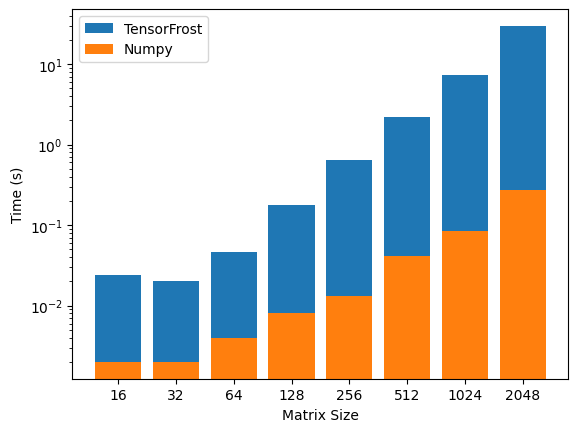

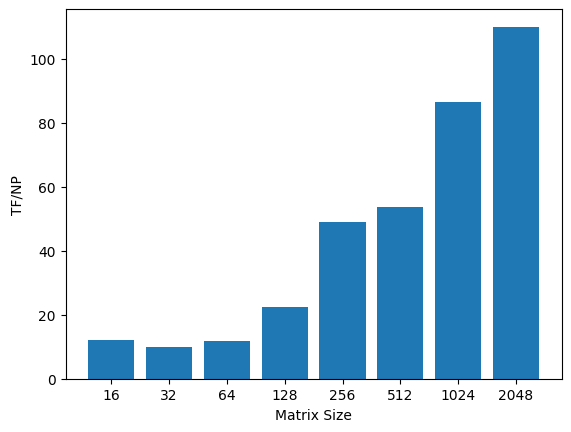

[0.02399897575378418, 0.01999974250793457, 0.04700016975402832, 0.18000054359436035, 0.6380016803741455, 2.1969990730285645, 7.341999530792236, 29.80799889564514]
[0.0020003318786621094, 0.0020003318786621094, 0.003999471664428711, 0.007999658584594727, 0.012999296188354492, 0.0410006046295166, 0.08500218391418457, 0.2709996700286865]


In [5]:
# Bar plot
size_str = [str(s) for s in sizes]
plt.bar(size_str, tf_times, label="TensorFrost")
plt.bar(size_str, np_times, label="Numpy")
plt.legend()
plt.xlabel("Matrix Size")
plt.ylabel("Time (s)")
plt.yscale("log")
plt.show()

# Bar plot with ratio
size_str = [str(s) for s in sizes]
plt.bar(size_str, [tf_times[i] / np_times[i] for i in range(len(sizes))])
plt.xlabel("Matrix Size")
plt.ylabel("TF/NP")
plt.show()


print(tf_times)
print(np_times)